In [1]:
llama_dir = '/mntcephfs/data/ruoyusun/liziniu/.cache/huggingface/hub/models--meta-llama--Llama-2-7b-hf/snapshots/8a0442e81540efaeb1a0fe3e95477b5e0edfd423'
from transformers import LlamaForCausalLM
llama = LlamaForCausalLM.from_pretrained(llama_dir,attn_implementation="eager")

/mntcephfs/lab_data/hanyizhou/anaconda/pe/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/mntcephfs/lab_data/hanyizhou/anaconda/pe/lib/python3.11/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969073/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
from torch import nn
import torch
class LlamaRotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None, scaling_factor=1.0):
        super().__init__()
        self.scaling_factor = scaling_factor
        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float().to(device) / self.dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)
        # For BC we register cos and sin cached
        self.max_seq_len_cached = max_position_embeddings
        t = torch.arange(self.max_seq_len_cached, device=device, dtype=torch.int64).type_as(self.inv_freq)
        t = t / self.scaling_factor
        freqs = torch.outer(t, self.inv_freq)
        # Different from paper, but it uses a different permutation in order to obtain the same calculation
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("_cos_cached", emb.cos().to(torch.get_default_dtype()), persistent=False)
        self.register_buffer("_sin_cached", emb.sin().to(torch.get_default_dtype()), persistent=False)
        


    @torch.no_grad()
    def forward(self, x, position_ids, seq_len=None):
        if seq_len is not None:
            logger.warning_once("The `seq_len` argument is deprecated and unused. It will be removed in v4.39.")

        # x: [bs, num_attention_heads, seq_len, head_size]
        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        position_ids_expanded = position_ids[:, None, :].float()
        # Force float32 since bfloat16 loses precision on long contexts
        # See https://github.com/huggingface/transformers/pull/29285
        device_type = x.device.type
        device_type = device_type if isinstance(device_type, str) else "cpu"
        with torch.autocast(device_type=device_type, enabled=False):
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            emb = torch.cat((freqs, freqs), dim=-1)
            cos = emb.cos()
            sin = emb.sin()
        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)
    



In [3]:
from transformers import AutoTokenizer
tokenizer_llama = AutoTokenizer.from_pretrained(llama_dir)
inputs_llama = tokenizer_llama("The decision left CNN Chief Medical Correspondent Sanjay Gupta as the only doctor at the hospital to get the patients through the night.", return_tensors="pt")
'''设计随机输入'''
#inputs_llama = tokenizer_llama('aodfasldfoajsdlfjasdofjaois difjaosidjfaois aosidjfoasdj doifajsdiofjaoisd iojoi oisadfjoai oijasodfjoij diosfjaios',return_tensors='pt')


outputs_llama = llama(**inputs_llama, labels = inputs_llama['input_ids'], output_attentions= True, output_hidden_states=True)
outputs_llama.loss,outputs_llama.attentions[0].shape

(tensor(2.8543, grad_fn=<NllLossBackward0>), torch.Size([1, 32, 30, 30]))

In [22]:
llama

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Lin

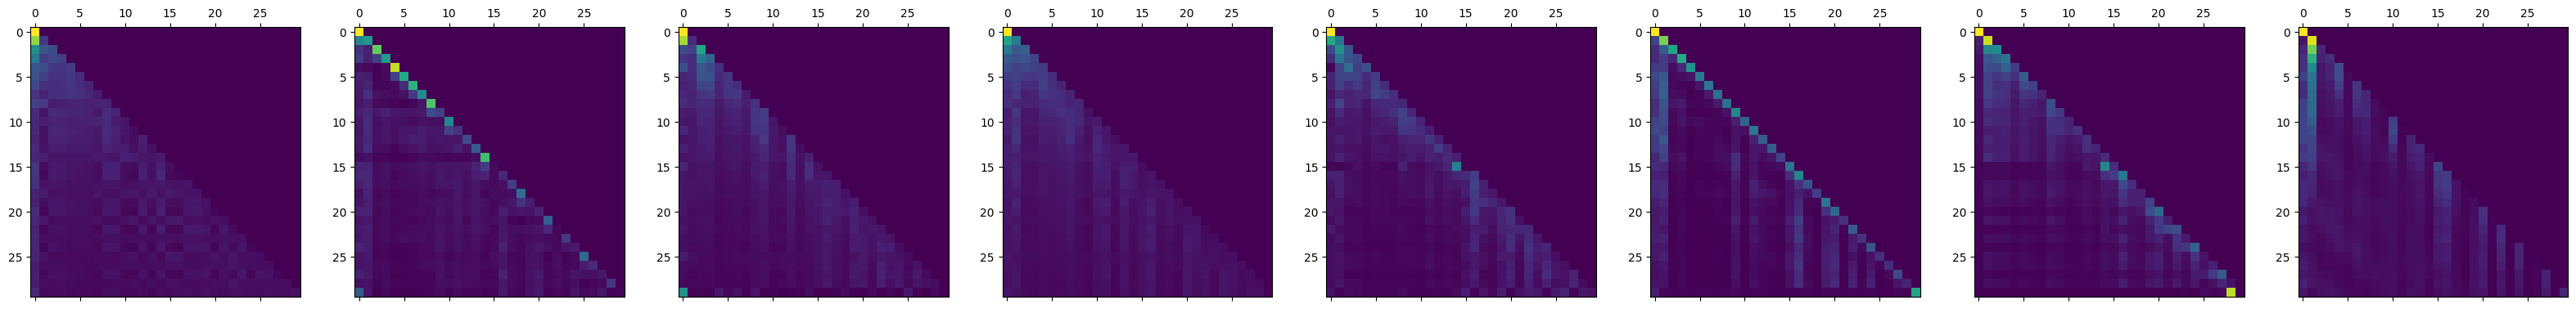

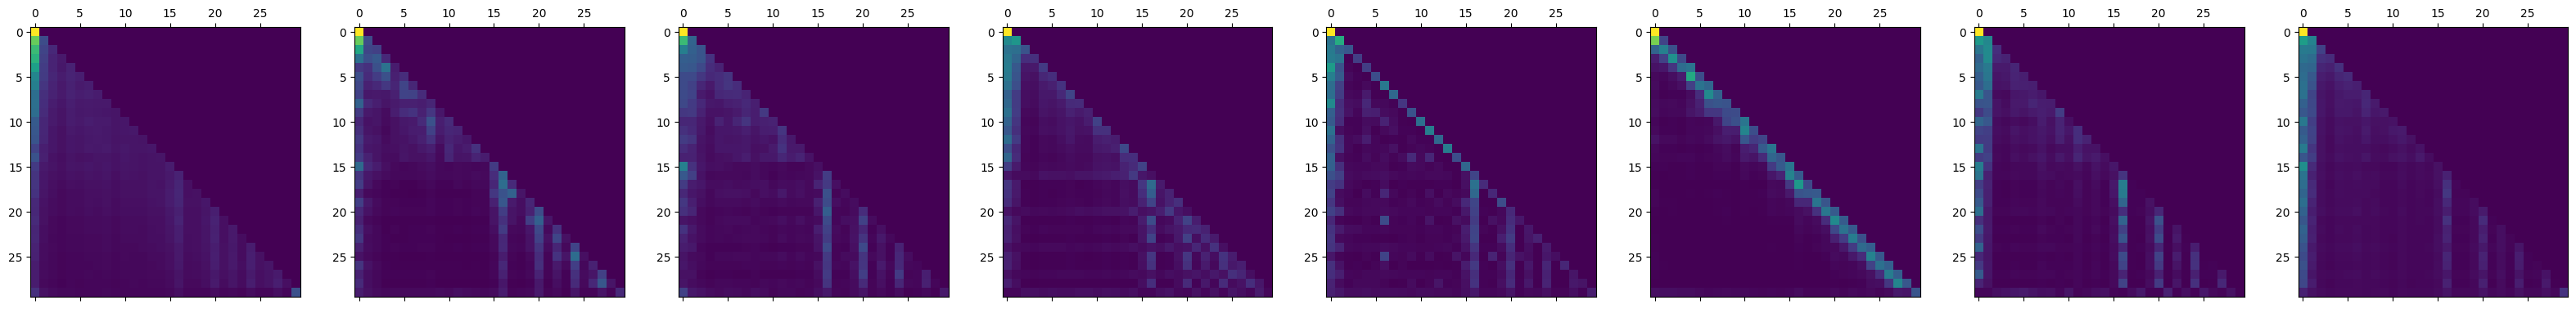

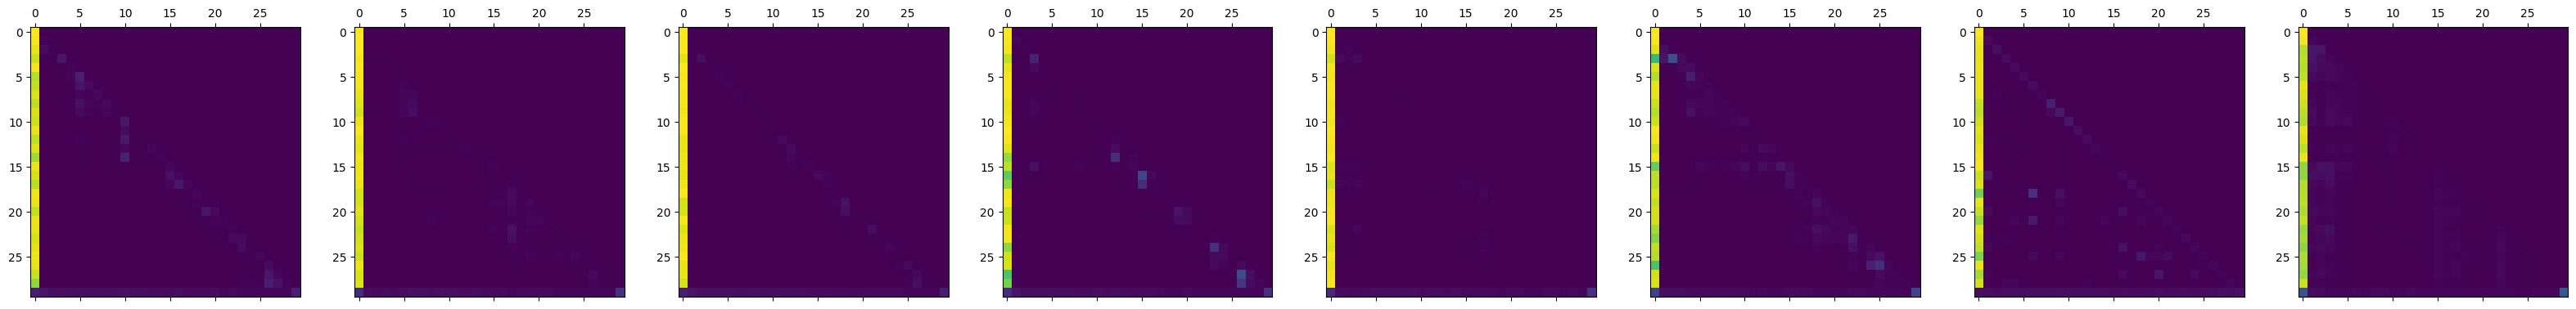

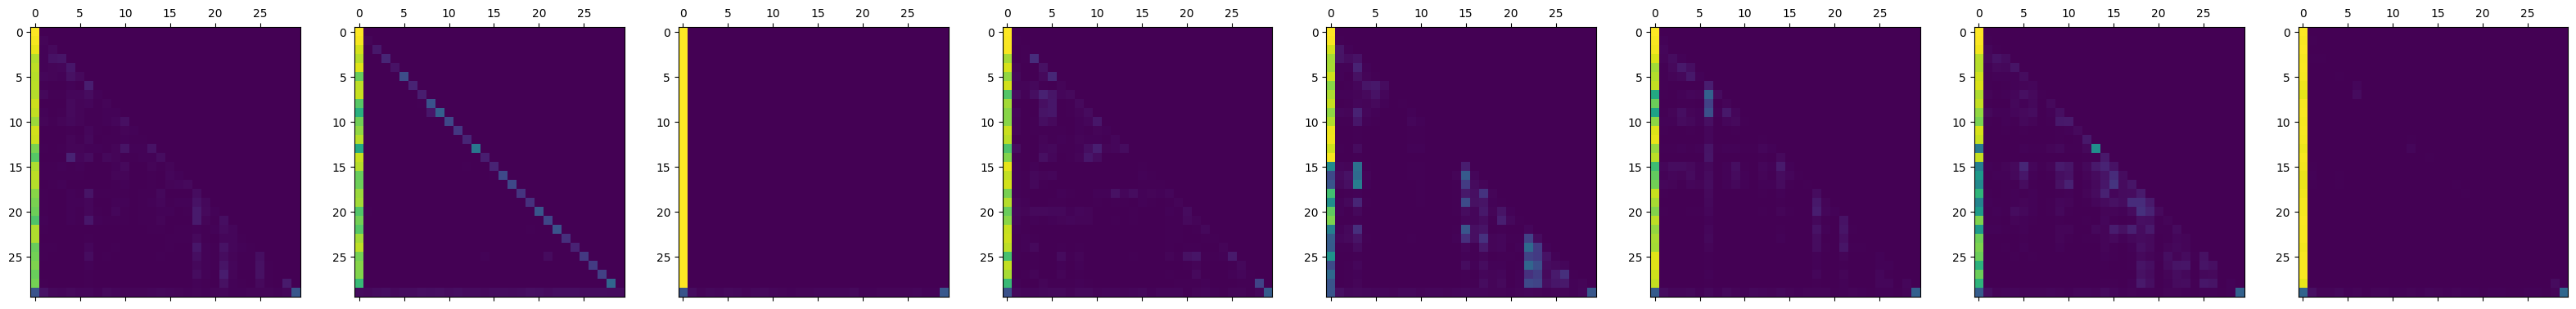

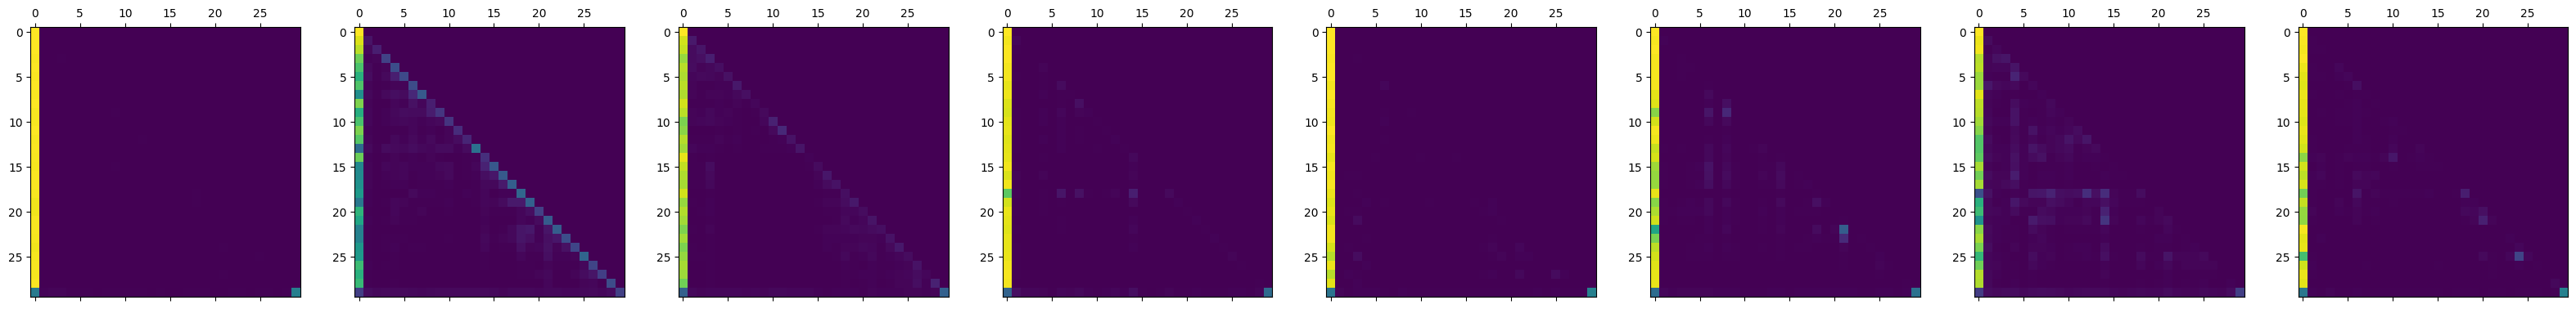

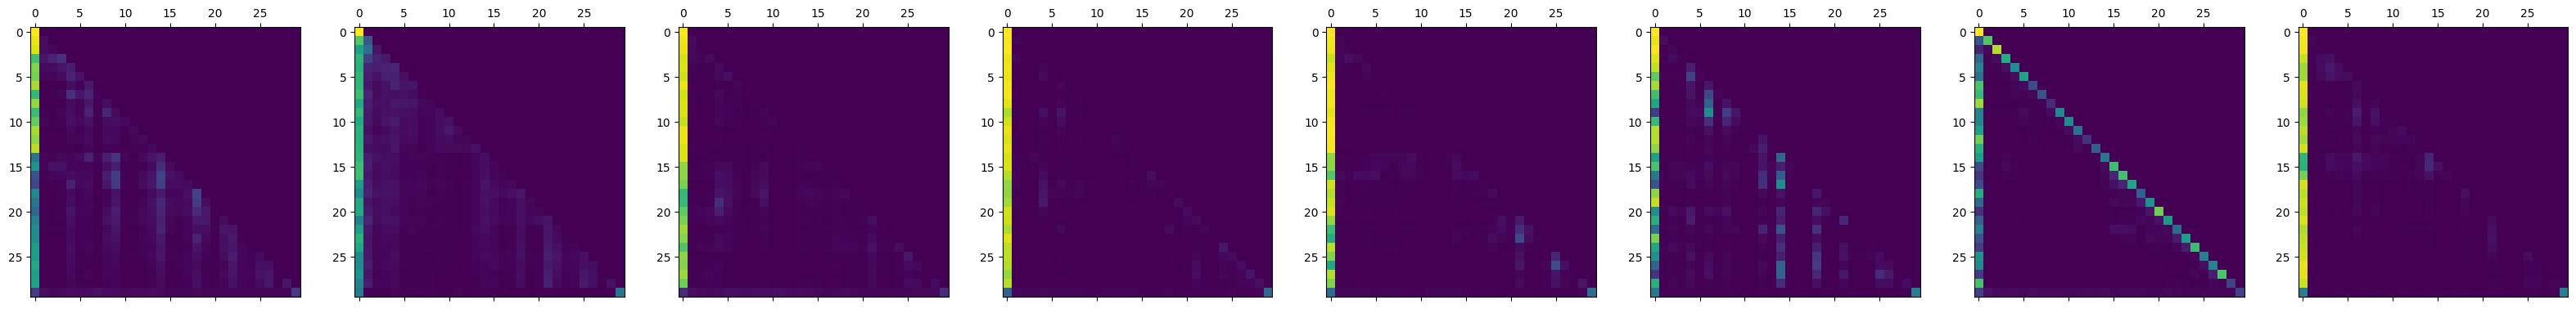

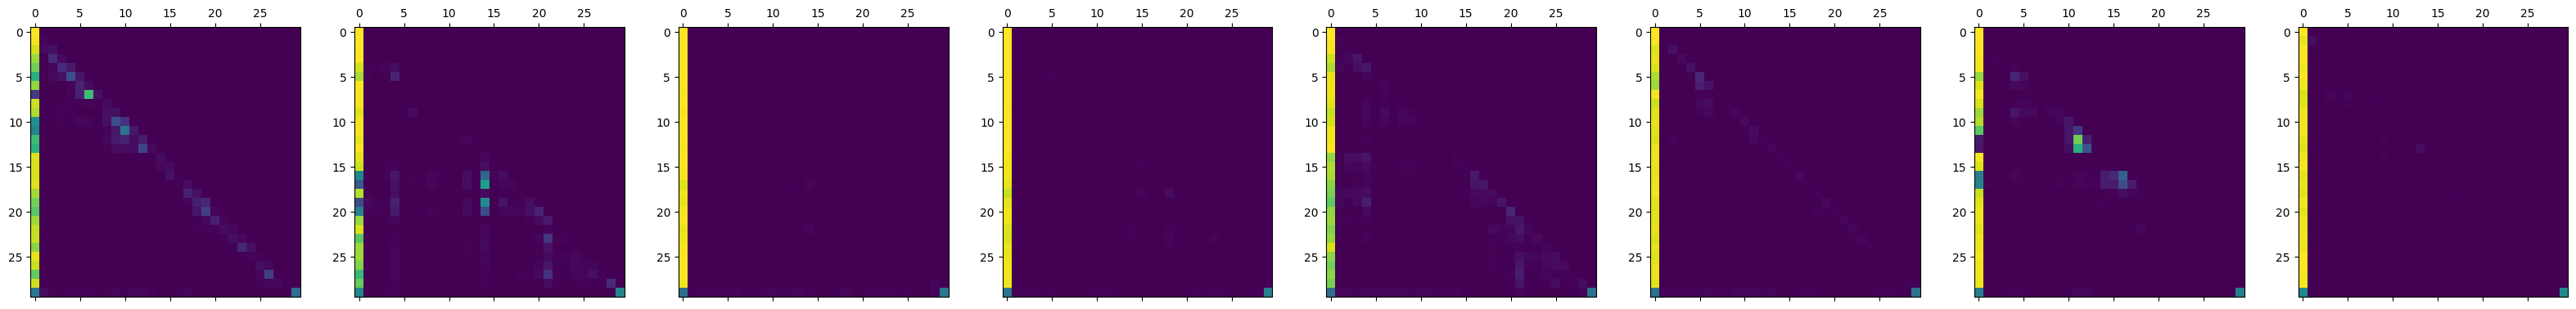

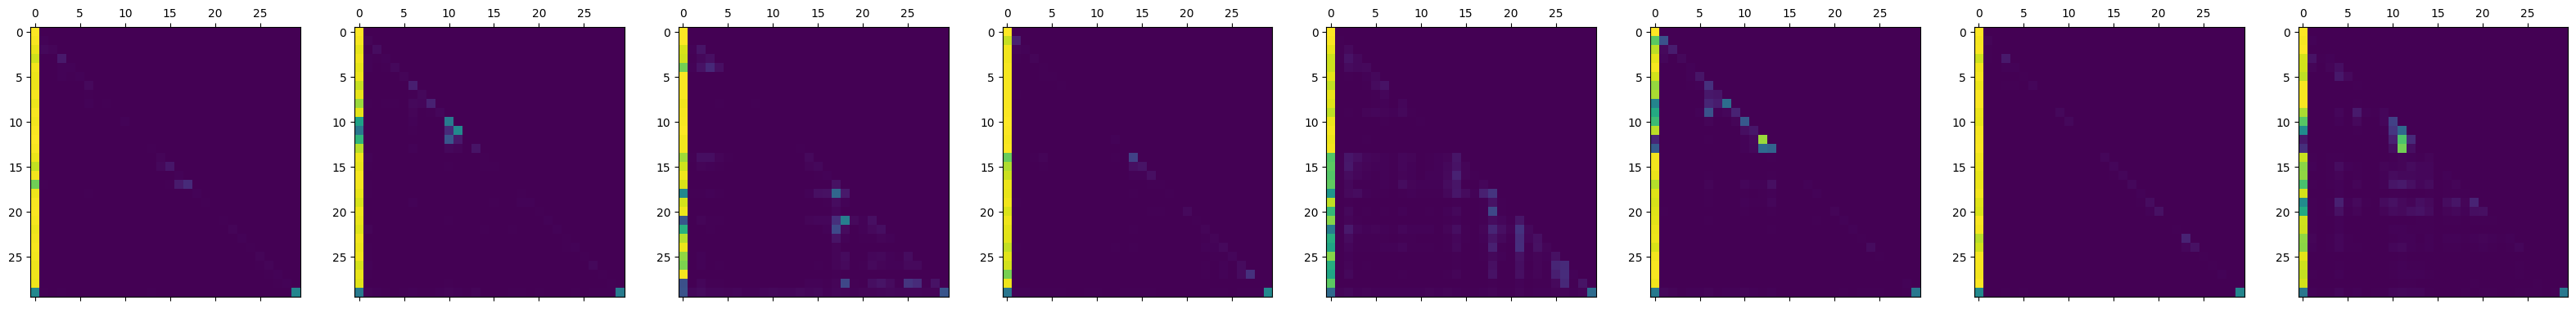

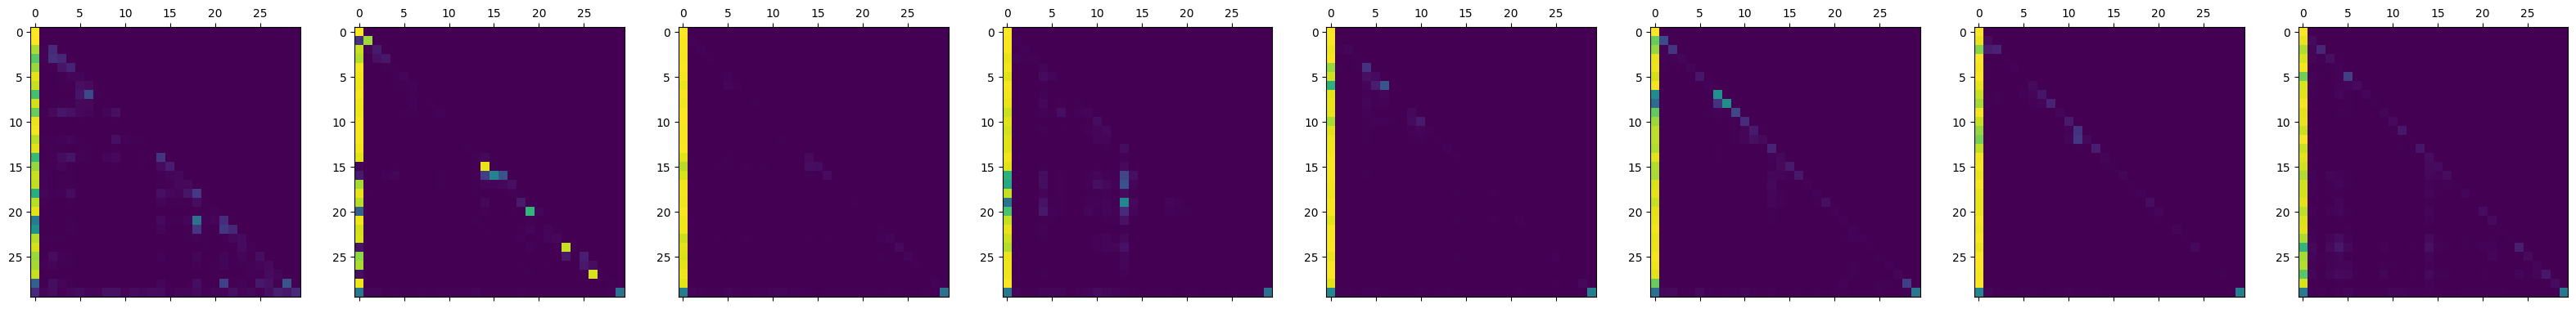

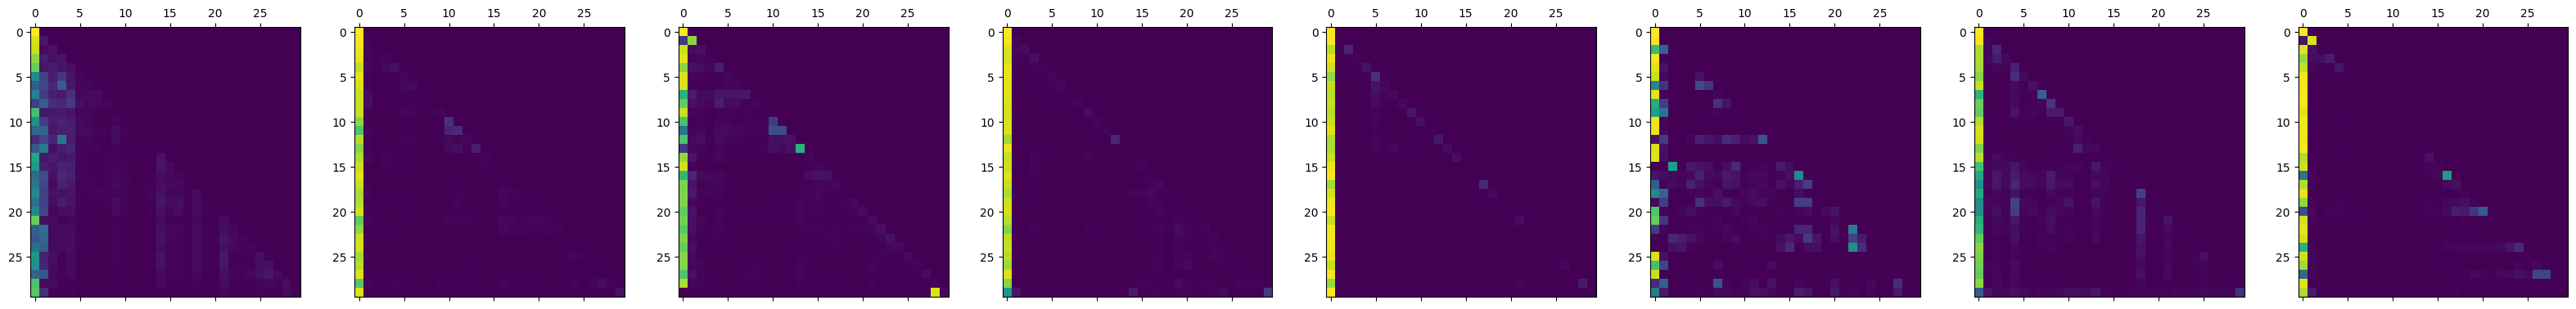

In [4]:
from matplotlib import pyplot as plt
attention_llama = [outputs_llama.attentions[i][0].detach().cpu().numpy() for i in range(32)]
vmin = min([_attention.min() for _attention in attention_llama])
vmax = max([_attention.max() for _attention in attention_llama])
#attention_pad = [outputs_pad.attentions[i][0].detach().cpu().numpy() for i in range(12)]
'''每个四层画一个, 每层画8个, 总计64个'''
fig,axes = plt.subplots(ncols=8,figsize = (40,5))
for i in range(8):
    axes[i].matshow(attention_llama[0][4*i+2],vmin=vmin, vmax=vmax)
fig,axes = plt.subplots(ncols=8,figsize = (40,5))
for i in range(8):
    axes[i].matshow(attention_llama[1][4*i+2],vmin=vmin, vmax=vmax)

for j in range(1,9):
    fig,axes = plt.subplots(ncols=8,figsize = (40,5))
    for i in range(8):
        axes[i].matshow(attention_llama[4*j-1][4*i+2],vmin=vmin, vmax=vmax)
    

## 计算位置编码提供的信息量:
一般的attention score计算: 
$$
a_{ij} = \tilde{q_i}^T\cdot \tilde{k_j}=x_i^T\cdot W_q^T\cdot R^{-i}\cdot R^j \cdot W_k\cdot x_j = q_i^T\cdot R^{j-i}\cdot k_j
$$

不添加位置编码的情况:
$$
\tilde{a_{ij}} = q_i^T\cdot k_j = x_i^T\cdot W_q\cdot W_k \cdot x_j
$$

二者做差: 
$$
\Delta = |a_{ij}-\tilde{a_{ij}}|
$$

In [4]:
layer_idx = 0
import torch
import math
max_positions = 4096
attn_bias = torch.tril(torch.ones((max_positions, max_positions), dtype=torch.bool)).view(
                1, 1, max_positions, max_positions
            )



def attention_score_wo_rotary(layer_idx, hidden_states, num_heads=32, head_dim = 128):
    bsz, q_len, _ = hidden_states.size()
    
    attn_model = llama.model.layers[layer_idx]
    
    layer_norm = attn_model.input_layernorm
    
    hidden_states = layer_norm(hidden_states)
    
    query_states = attn_model.self_attn.q_proj(hidden_states)
    key_states = attn_model.self_attn.k_proj(hidden_states)
    value_states = attn_model.self_attn.v_proj(hidden_states)
    
    query_states = query_states.view(bsz, q_len, num_heads, head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, q_len, num_heads, head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, q_len, num_heads,head_dim).transpose(1, 2)
    
    attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(head_dim)
    attn_shape = attn_weights.shape
    
    query_length, key_length = attn_shape[-2],attn_shape[-1]
    causal_mask = attn_bias[:, :, key_length - query_length : key_length, :key_length]
    mask_value = torch.finfo(attn_weights.dtype).min
    mask_value = torch.full([], mask_value, dtype=attn_weights.dtype, device=attn_weights.device)
    attn_weights = torch.where(causal_mask, attn_weights.to(attn_weights.dtype), mask_value)
    return attn_weights[0]
    

In [5]:
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

def attention_score_with_rotary(layer_idx, hidden_states, num_heads=32, head_dim = 128):
    bsz, q_len, _ = hidden_states.size()
    position_ids = torch.arange(q_len).unsqueeze(0)
    rope_theta = llama.config.rope_theta
    rotary_emb = LlamaRotaryEmbedding(
                head_dim,
                max_position_embeddings=4096,
                base=rope_theta,
            )
    # rotary_emb = LlamaRotaryEmbedding_var(
    #             head_dim,
    #             max_position_embeddings=4096,
    #             base=rope_theta,
    #         )
    attn_model = llama.model.layers[layer_idx]

    layer_norm = attn_model.input_layernorm

    hidden_states = layer_norm(hidden_states)

    query_states = attn_model.self_attn.q_proj(hidden_states)
    key_states = attn_model.self_attn.k_proj(hidden_states)
    value_states = attn_model.self_attn.v_proj(hidden_states)

    query_states = query_states.view(bsz, q_len, num_heads, head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, q_len, num_heads, head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, q_len, num_heads,head_dim).transpose(1, 2)

    cos, sin = rotary_emb(value_states, position_ids)
    query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

    attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(head_dim)
    attn_shape = attn_weights.shape
    
    query_length, key_length = attn_shape[-2],attn_shape[-1]
    causal_mask = attn_bias[:, :, key_length - query_length : key_length, :key_length]
    mask_value = torch.finfo(attn_weights.dtype).min
    mask_value = torch.full([], mask_value, dtype=attn_weights.dtype, device=attn_weights.device)
    attn_weights = torch.where(causal_mask, attn_weights.to(attn_weights.dtype), mask_value)
    return attn_weights[0]

In [6]:
attn_with = attention_score_with_rotary(layer_idx=30, hidden_states=outputs_llama.hidden_states[0])
attn_without = attention_score_wo_rotary(layer_idx=30, hidden_states=outputs_llama.hidden_states[0])
delta = torch.abs(attn_without-attn_with)
delta = delta/torch.abs(attn_with)

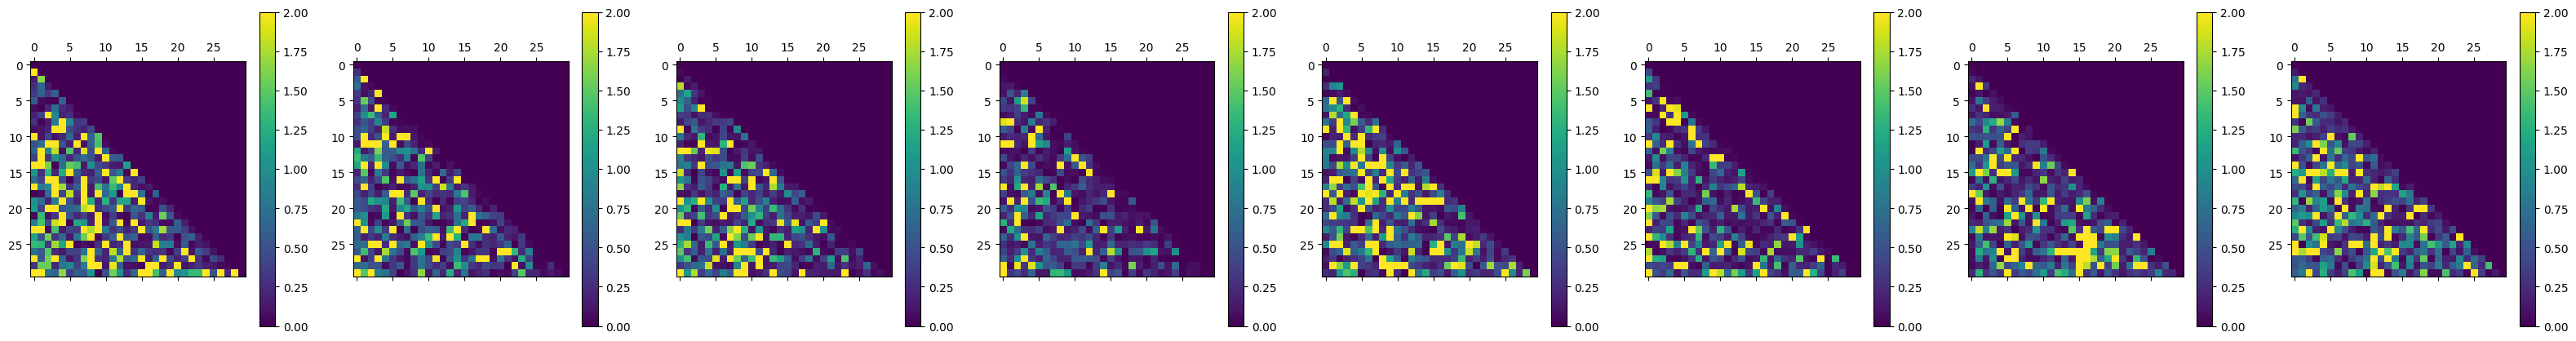

In [7]:
from matplotlib import pyplot as plt
attention_llama = [delta[i].detach().cpu().numpy() for i in range(32)]
vmin = min([_attention.min() for _attention in attention_llama])
vmax = max([_attention.max() for _attention in attention_llama])
#attention_pad = [outputs_pad.attentions[i][0].detach().cpu().numpy() for i in range(12)]
'''每个四层画一个, 每层画8个, 总计64个'''
fig,axes = plt.subplots(ncols=8,figsize = (40,5))
for i in range(8):
    im = axes[i].matshow(attention_llama[4*i+2],vmax = 2, vmin=vmin)
    plt.colorbar(im,ax=axes[i])
# fig,axes = plt.subplots(ncols=8,figsize = (40,5))
# for i in range(8):
#     axes[i].matshow(attention_llama[1][4*i+2])


### 将前面token的位置编码归零, 即不对前N个token旋转

In [8]:
def token_shift(N, sequence_length):
    pos = torch.arange(sequence_length-N+1).view(1,-1)
    zero = torch.zeros(1,N-1)
    return  torch.cat((zero,pos), dim = 1)
def token_mask(N,sequence_length):
    pos = torch.arange(sequence_length).view(1,-1)
    zero = torch.zeros(1,N)
    return torch.cat((zero,pos[:,N:]),dim=-1)
sequence_length = inputs_llama.input_ids.shape[-1]
loss = []
for N in range(sequence_length):
    position_ids = token_mask(N, sequence_length)
    outputs_llama_mask = llama(**inputs_llama, labels = inputs_llama['input_ids'], output_attentions= True, output_hidden_states=True, position_ids = position_ids)
    loss.append(outputs_llama_mask.loss.detach().numpy())

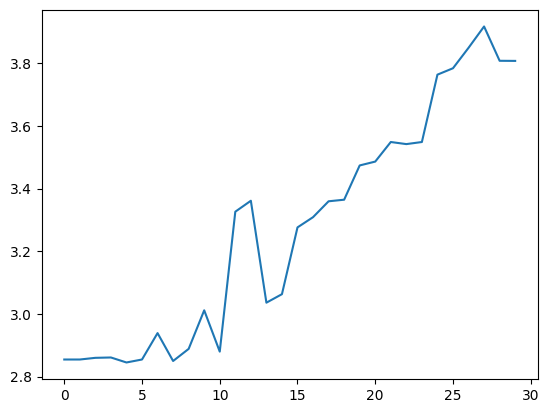

In [13]:
import numpy as np
loss = np.array(loss)
x = np.arange(len(loss))
plt.plot(x,loss)

## 修改第一个token的旋转角度

In [24]:
position_ids = torch.arange(sequence_length).view(1,-1)
position_ids[0][-1] = 3000
position_ids.long()
outputs_llama_mask = llama(**inputs_llama, labels = inputs_llama['input_ids'], output_attentions= True, output_hidden_states=True, position_ids = position_ids)

In [25]:
outputs_llama_mask.loss

tensor(2.8543, grad_fn=<NllLossBackward0>)

In [26]:
position_ids

tensor([[   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
           12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
           24,   25,   26,   27,   28, 3000]])

In [14]:
data_dir = '/mntcephfs/data/ruoyusun/hanyizhou/wikitext-103/dataset/Salesforce_wikitext'
from datasets import load_dataset
data_test = load_dataset(data_dir)
encodings = tokenizer_llama("\n\n".join(data_test['train'][:10]['text']), return_tensors="pt",truncation=True, max_length=1000)

In [16]:
# sequence_length = encodings.input_ids.shape[-1]
# loss = []
# from tqdm import tqdm
# for N in tqdm(range(1,1000)):
#     position_ids = token_mask(N, sequence_length)
#     with torch.no_grad():
#         output = llama(**encodings,labels = encodings['input_ids'],output_attentions= True, output_hidden_states=True, position_ids = position_ids)
#     loss.append(output.loss.numpy())


In [17]:
loss = np.array(loss)


In [18]:
output.loss

NameError: name 'output' is not defined

### 根据上面的实验结果, 即便是4096长度的sequence, loss也没有太大的提升, 因此, 在RopE式的编码中, 位置信息似乎没有"那么重要". 
补充: 根绝我在GPT2中的实验, 如果仍旧用位置信息提供bias这一套说法的话, 我觉得更合适的是: 模型根据位置做预测, 但是语义信息提供bias.